<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis

In [1]:
import os

# Desactiva la optimización de memoria de TensorFlow
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
import tensorflow
from transformers import TFBertModel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from tensorflow.keras.utils import to_categorical

from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

from sklearn.model_selection import train_test_split

2024-05-03 14:31:58.840112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 14:31:58.840157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 14:31:58.840178: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 14:31:58.845880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/workspaces/procesamiento_lenguaje_natural/.venv/l

### Definiendo modelo

In [3]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased") # BERT-Base

2024-05-03 14:29:04.660640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 14:29:04.678149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 14:29:04.678298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Se setea el output_shape a 5 para entrenar al modelo con las 5 clases presentes en el dataset que se empleará.

In [3]:
max_length = 140
output_shape = 5

In [5]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

dense_layer = tensorflow.keras.layers.Dense(units=128, activation='relu')(pooled_output)
x = tensorflow.keras.layers.Dropout(0.2)(dense_layer)

# x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)


output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model1 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [6]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

In [4]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('apps.csv', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download'
    output = 'apps.csv'
    gdown.download(url, output, quiet=False)
else:
    print("apps.csv ya se encuentra descargado")
if os.access('reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download'
    output = 'reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("reviews.csv ya se encuentra descargado")

apps.csv ya se encuentra descargado
reviews.csv ya se encuentra descargado


In [6]:
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [7]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


In [8]:
if df['score'].max() == 5:
    df['score'] = df['score'] - 1 # comienza desde 0 al 4, esto es para que to_categorical genera la cantidad adecuada de clases.

In [9]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,0,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,0,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,0,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",0,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,0,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


<Axes: xlabel='score', ylabel='count'>

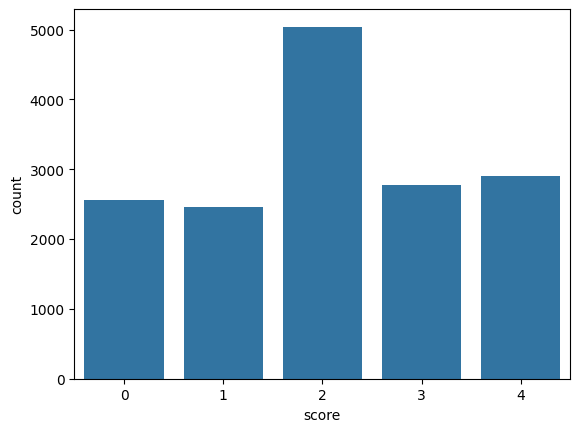

In [10]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

## Limpieza de datos

A fin de balancear los datos, se elminarán al azar entradas con el valor 2 en df.score.

In [14]:
# # Balancear los datos
# def delete_rows_with_value(df, column, value, target_count):
#     # Get indices of rows with the specified value
#     indices = df.index[df[column] == value].tolist()
    
#     # Shuffle the indices randomly
#     np.random.shuffle(indices)
    
#     # Determine the number of rows to delete
#     num_rows_to_delete = max(0, len(indices) - target_count)
    
#     # Delete the rows
#     for i in range(num_rows_to_delete):
#         df.drop(indices[i], inplace=True)

# target_count = 3000

# delete_rows_with_value(df, 'score', 2, target_count)

In [15]:
# # ¿Cómo quedaron balanceados los datos?
# sns.countplot(x=df.score)

In [11]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


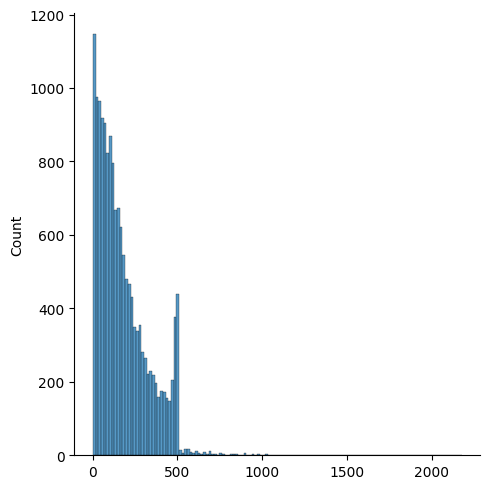

In [12]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [13]:
y = df['score'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


## 1 - Data generator

In [14]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente

max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [16]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [17]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [18]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

2024-05-03 14:33:01.520220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 14:33:01.523713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 14:33:01.523833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [19]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [20]:
X_test = [tf_batch['input_ids'],  
          tf_batch['attention_mask']]

In [21]:
y_test = y[idx_test]

## 2 - BERT multiclass classification

In [26]:
history1 = model1.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5


2024-05-02 18:22:38.130300: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f29f2e04990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-02 18:22:38.130322: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-02 18:22:38.136151: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-02 18:22:38.153879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-05-02 18:22:38.228239: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    315/Unknown - 100s 290ms/step - loss: 1.5446 - accuracy: 0.3342 - f1_score: 0.1867

2024-05-02 18:24:09.706441: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15898602984980637846
2024-05-02 18:24:09.706471: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13664866260885649574
2024-05-02 18:24:09.706482: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14954186756816402449
2024-05-02 18:24:09.706495: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13113141461436483487
2024-05-02 18:24:33.580370: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13664866260885649574
2024-05-02 18:24:33.580421: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15898602984980637846
2024-05-02 18:24:33.580431: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous se

315/315 [==============================] - 125s 367ms/step - loss: 1.5446 - accuracy: 0.3342 - f1_score: 0.1867 - val_loss: 1.4991 - val_accuracy: 0.3444 - val_f1_score: 0.1899
Epoch 2/5
315/315 [==============================] - 114s 363ms/step - loss: 1.4568 - accuracy: 0.3698 - f1_score: 0.2172 - val_loss: 1.3770 - val_accuracy: 0.4278 - val_f1_score: 0.2818
Epoch 3/5
315/315 [==============================] - 114s 362ms/step - loss: 1.3873 - accuracy: 0.4001 - f1_score: 0.2679 - val_loss: 1.3343 - val_accuracy: 0.4440 - val_f1_score: 0.2989
Epoch 4/5
315/315 [==============================] - 114s 363ms/step - loss: 1.3707 - accuracy: 0.4054 - f1_score: 0.2870 - val_loss: 1.3142 - val_accuracy: 0.4405 - val_f1_score: 0.3182
Epoch 5/5
315/315 [==============================] - 114s 363ms/step - loss: 1.3425 - accuracy: 0.4195 - f1_score: 0.3111 - val_loss: 1.3047 - val_accuracy: 0.4385 - val_f1_score: 0.3203


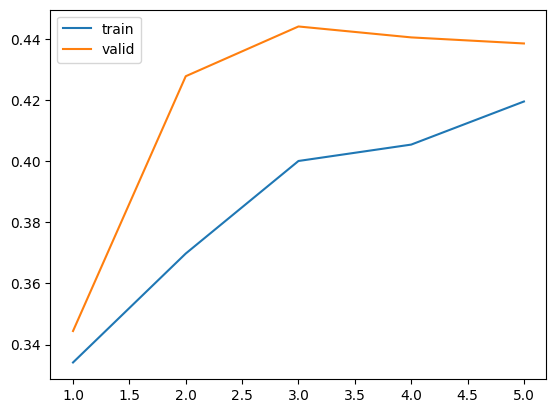

In [27]:
plot_train_metrics(history1)

In [28]:
y_hat_prob = model1.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 29s 273ms/step


array([[0.28019097, 0.23891833, 0.35060504, 0.09690775, 0.03337784],
       [0.21720767, 0.20387451, 0.31021354, 0.16827074, 0.10043346],
       [0.06647879, 0.10888895, 0.33861232, 0.3000007 , 0.18601923]],
      dtype=float32)

In [29]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [30]:
# Calcular la exactitud (accuracy)
scores = model1.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 29s 275ms/step - loss: 1.3109 - accuracy: 0.4213 - f1_score: 0.3131


0.42126983404159546

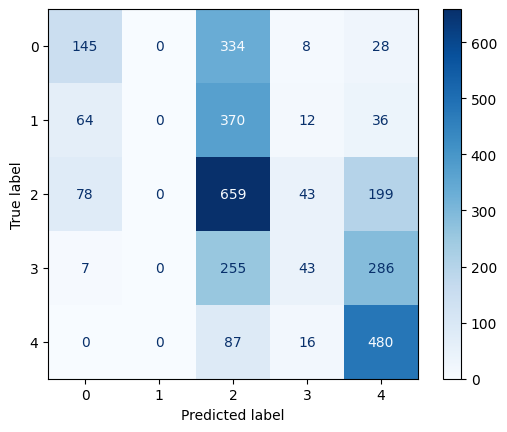

In [31]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

Se guarda el modelo

In [32]:
model1.save_weights('bert_model1_weights.h5')

## 3 - BERT Fine tuning

Los resultados obtenidos del `model1` no han sido satisfactorios. A fin de mejorar la performance se creará un nuevo `model2` en donde:

1. Se marcarán todos los layers del modelo como entrenables
2. Se bajará el learning rate de forma considerable.
3. Se empleará un BERT model más pequeño.

El modelo BERT-Base es demasiado grande para entrenar en tiempos lógicos y con recursos reducidos. Se empleará un modelo más pequeño a fin de realizar el fine tunning.

In [22]:
# bert_model_2 = TFBertModel.from_pretrained("bert-base-uncased") # BERT-Base

# bert_model_2 = TFBertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2") # BERT-Tiny

# bert_model_2 = TFBertModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4", from_pt=True) # BERT-Mini (PyTorch)

# bert_model_2 = TFBertModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8", from_pt=True) # BERT-Small (PyTorch)

bert_model_2 = TFBertModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8", from_pt=True) # BERT-Medium (PyTorch)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [23]:
# Se colocan todas las capas como entrenables
bert_model_2.bert.trainable = True

input_ids_2 = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask_2 = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs_2 = bert_model_2(input_ids_2, attention_mask=attention_mask_2)

pooled_output_2 = outputs_2.pooler_output

dense_layer_2 = tensorflow.keras.layers.Dense(units=128, activation='relu')(pooled_output_2)
x_2 = tensorflow.keras.layers.Dropout(0.2)(dense_layer_2)

# x_2 = tensorflow.keras.layers.Dropout(0.2)(pooled_output_2)

output_2 = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x_2)

model2 = tensorflow.keras.Model(inputs=[input_ids_2, attention_mask_2], outputs=output_2)

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces menor
model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   4137318   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   4          'attention_mask[0][0]']      
                             hidden_state=(None, 140, 5                                       

In [ ]:
# # Clonar el modelo
# model2 = tensorflow.keras.models.clone_model(model1)

# # Colocar todas las layers como entrenables
# for layer in model2.layers:
#   layer.trainable = True

# # Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces menor
# model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

# model2.summary()

Se entrenarán 15 epochs a diferencia del caso anterior, en donde el accuracy en validación ya bajaba en la 5ta epoch. En este caso, vemos que al realizar un fine tunning tiene más sentido aumentar el número de epochs debido al learning rate reducido.

In [24]:
history2 = model2.fit(train_data, epochs=15, validation_data=validation_data)

Epoch 1/15


2024-05-03 14:35:10.540147: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f324402bca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 14:35:10.540184: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-03 14:35:10.546313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-03 14:35:10.564397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-05-03 14:35:10.638740: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    315/Unknown - 108s 286ms/step - loss: 1.3818 - accuracy: 0.3989 - f1_score: 0.3312

2024-05-03 14:36:46.924954: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7962799445814330280
2024-05-03 14:36:46.924984: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10794014932893459610
2024-05-03 14:36:46.924991: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 18442187511970849115
2024-05-03 14:36:46.924996: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10810499077690784959


315/315 [==============================] - 118s 317ms/step - loss: 1.3818 - accuracy: 0.3989 - f1_score: 0.3312 - val_loss: 1.1712 - val_accuracy: 0.5028 - val_f1_score: 0.4306
Epoch 2/15


2024-05-03 14:36:56.554836: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10017259478168063152
2024-05-03 14:36:56.554865: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 8813057131475648066
2024-05-03 14:36:56.554877: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14790023436279935187
2024-05-03 14:36:56.554889: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 9181048561619411919
2024-05-03 14:36:56.554897: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10847515940055844153


315/315 [==============================] - 99s 315ms/step - loss: 1.1559 - accuracy: 0.4994 - f1_score: 0.4573 - val_loss: 1.0964 - val_accuracy: 0.5310 - val_f1_score: 0.4788
Epoch 3/15
315/315 [==============================] - 99s 315ms/step - loss: 1.0540 - accuracy: 0.5501 - f1_score: 0.5188 - val_loss: 1.0375 - val_accuracy: 0.5647 - val_f1_score: 0.5167
Epoch 4/15
315/315 [==============================] - 99s 315ms/step - loss: 0.9659 - accuracy: 0.6003 - f1_score: 0.5766 - val_loss: 1.0056 - val_accuracy: 0.5857 - val_f1_score: 0.5599
Epoch 5/15
315/315 [==============================] - 99s 315ms/step - loss: 0.8757 - accuracy: 0.6398 - f1_score: 0.6215 - val_loss: 0.9891 - val_accuracy: 0.6071 - val_f1_score: 0.5807
Epoch 6/15
315/315 [==============================] - 99s 316ms/step - loss: 0.7719 - accuracy: 0.6970 - f1_score: 0.6839 - val_loss: 0.9776 - val_accuracy: 0.6242 - val_f1_score: 0.6098
Epoch 7/15
315/315 [==============================] - 99s 316ms/step - loss:

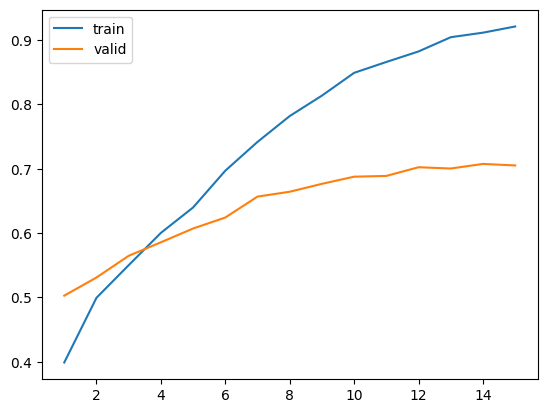

In [25]:
plot_train_metrics(history2)

In [26]:
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:3]

99/99 [==============================] - 11s 100ms/step


array([[1.6173929e-02, 7.6256320e-02, 4.1520724e-01, 4.9026328e-01,
        2.0991890e-03],
       [1.2353429e-03, 2.1856843e-02, 9.7569883e-01, 6.2613958e-04,
        5.8285892e-04],
       [6.4019655e-04, 2.3475688e-04, 1.4124147e-02, 9.8372132e-01,
        1.2795227e-03]], dtype=float32)

In [27]:
y_hat2 = np.argmax(y_hat_prob2, axis=1)

In [28]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 11s 102ms/step - loss: 1.2385 - accuracy: 0.6971 - f1_score: 0.6880


0.6971428394317627

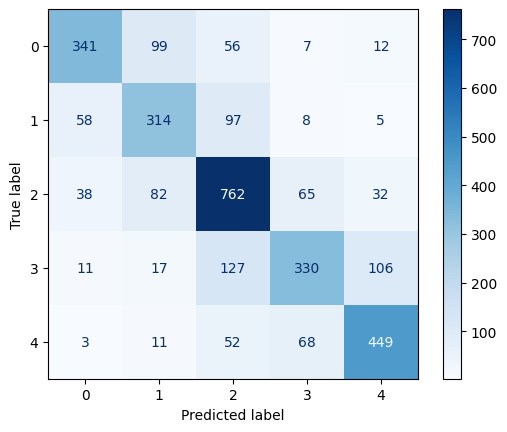

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat2)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

Se guarda el modelo

In [30]:
model2.save_weights('bert_model2_weights.h5')

## 4 - Conclusiones

Se observa que empleando una estrategia de fine tunning se obtienen resultados muy superiores al caso en donde se emplea la estrategia de feature extractor. Si bien se observa que el `model2` experimentó cierto overfitting, se lo elige por sobre el otro sin lugar a dudas.

Queda claro que si bien realizar fine tunning es costoso, conviene emplear un modelo reducido de BERT e intentar por todos los medios utilizar esta estrategia.